Elapsed time: 2.9810240999941016


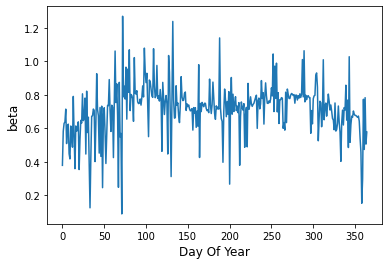

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd 
from time import perf_counter



df = pd.read_csv("data3.csv") 
slopes = []
gammas = []
def beta_back_calculation(t0,t3,timehorizon):
    t2 = 1/3*t0 + 2/3 * t3
    day = 0
    temperatureDayArr = []
    GHIDayArr = []
    mu = []
    gamma = 0
    for i in np.arange(int(len(df['Minute']))):
        if(df['Minute'][i] % 1440 == 0):
            if(day > 0):
                mut0t2 = 0
                sum_mut0t2 = 0
                sum_lambdat2t3 = 0
                netflow = 0
                netflowt2t3 = 0
                sum_netflow = 0
                slope = 1
                queueArr = []
                eqn_queue = []
                for k in np.arange(int(t0/timehorizon),int(t2/timehorizon)+1):
                    mut0t2 = ((GHIDayArr[int(t2/timehorizon)]-GHIDayArr[int(t0/timehorizon)])/((t2-t0)/timehorizon))*(k-t0/timehorizon)+GHIDayArr[int(t0/timehorizon)]
                    sum_mut0t2 += mut0t2
                    netflow = GHIDayArr[int(k)] - mut0t2
                    sum_netflow += netflow
                    queueArr.append(sum_netflow)
                queue = sum_netflow
                for k in np.arange(int(t2/timehorizon),int(t3/timehorizon)+1):
                    sum_lambdat2t3 += GHIDayArr[int(k)]
                #print(sum_lambdat2t3)
                func_approx(slope,sum_netflow,GHIDayArr[int(int(t2/timehorizon))], GHIDayArr,sum_lambdat2t3,t2,t3,timehorizon,.09)
                slope = slopes[len(slopes) - 1 ]
                for k in np.arange(0,int(t3/timehorizon)-int(t2/timehorizon)):
                    y = slope*k + GHIDayArr[int(int(t2/timehorizon))]
                    netflowt2t3 = GHIDayArr[int(k) + int(t2/timehorizon)] - y
                    queue += netflowt2t3
                    queueArr.append(queue)
                #plt.subplot(queueArr)
                for k in np.arange(int(t0/timehorizon),int(t3/timehorizon)+1):
                    y = 1/3*((k - int(t0/timehorizon))**2)*(int(t3/timehorizon) - k)
                    eqn_queue.append(y)
                #print(eqn_queue)
                #print("queue t2 t3: " + str(queue))
                #print("queue t0 t2: " + str(sum_netflow))
                gamma = linest(queueArr,eqn_queue)
                gammas.append(gamma[0])
            temperatureDayArr.clear()
            GHIDayArr.clear();        
            day += 1
        temperatureDayArr.append(df['Average of Temperature'][i])
        GHIDayArr.append(df['Average of GHI'][i])
def linest(x, y):
    gamma = np.polyfit(y,x,1)
    return gamma
     
     
def func_approx(slope,netflow,lambdat2, lambda_arr, total_lambda,t2,t3,timehorizon,step):
    error = 0
    total_mu = 0
    curr_netflow = 0
    queue = 0
    #y = mx+b
    for k in np.arange(0,int(t3/timehorizon)-int(t2/timehorizon)):
        y = slope*k + lambdat2
        #print(y)
        total_mu += y
        curr_netflow = y- lambda_arr[k + int(t2/timehorizon)]
        queue += curr_netflow

    if(abs(queue - netflow) < 0.001):
        slopes.append(slope)
        #print("final slope: " + str(slope))
        #print("final netflow: " + str(netflow))
        #print("final queue: " + str(queue))
    else:
        #print("queue: " + str(queue))
        #print("netflow: " + str(netflow))
        if(queue < netflow):
            slope += step
        if(queue > netflow):
            slope -= step
        if(abs(queue - netflow) < 12):
            step /= 1.5
        func_approx(slope,netflow,lambdat2, lambda_arr,total_lambda,t2,t3,timehorizon,step)

def plot_beta():
    plt.plot(gammas)
    plt.ylabel('beta', fontsize=12)
    plt.xlabel('Day Of Year', fontsize=12)

if __name__=="__main__":
    t1_start = perf_counter()
    beta_back_calculation(450,1080,10)
    t1_stop = perf_counter()
    
    plot_beta()
    print("Elapsed time:", t1_stop - t1_start)
